# importing libraries



In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt
import math
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc,recall_score,precision_score,f1_score,roc_auc_score,accuracy_score,confusion_matrix

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1468192881520334154
xla_global_id: -1
]


In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
%cd C:\Users\Nikolay\Downloads\srnet

[WinError 3] Системе не удается найти указанный путь: 'C:\\Users\\Nikolay\\Downloads\\srnet'
C:\Users\Home\Downloads


In [8]:
image_stego = cv2.imread(r"C:\Users\CoolerMaster\Downloads\last_dataset_pgm_UNIWARD/train/0\1.pgm", cv2.IMREAD_UNCHANGED)
image_cover = cv2.imread(r"C:\Users\CoolerMaster\Downloads\last_dataset_pgm_UNIWARD/train/1\1.pgm", cv2.IMREAD_UNCHANGED)
abs(image_cover.astype(np.single)-image_stego.astype(np.single)).mean()

AttributeError: 'NoneType' object has no attribute 'astype'

In [ ]:
(image_cover-image_stego).mean()

In [ ]:
image_stego.shape

In [ ]:
plt.imshow(image_cover)

In [ ]:
image_cover.shape

In [ ]:
import numpy as np
import random
import os
import cv2
import tensorflow as tf
import math

class PairedImageGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dim=(256, 256), n_channels=1, batch_size=16, images_path_cover='/', images_path_stego='/', shuffle=True, augment=True, seed=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.images_path_stego = images_path_stego
        self.images_path_cover = images_path_cover
        self.shuffle = shuffle
        self.augment = augment

        # Set the seed
        if seed != None:
            np.random.seed(seed)
            tf.random.set_seed(seed)
        
        # cover and stego filenames should be the same
        self.image_names = os.listdir(self.images_path_cover)
        self.indices = np.arange(len(self.image_names))

        # Shuffle the indices
        self.shuffle_indices()


    def __getitem__(self, i):
        # Select the indices that should be used now
        inds = self.indices[i * (self.batch_size//2):(i + 1) * (self.batch_size//2)]

        # Select the filenames
        batch_filenames = [self.image_names[i] for i in inds]

        # Get the X and the y
        X, y = self.__data_generation(batch_filenames)

        return X, y
    

    def __len__(self):
        return math.ceil(len(self.image_names) / (self.batch_size//2))


    def on_epoch_end(self):
        self.shuffle_indices()


    def preprocessing(self, image):
        image = image
        return image


    def data_augmentation(self, cover, stego):
        rotation = np.random.choice([-1, 0, 1])
        # Rotate the image 90, -90 or 0 degrees.
        cover = np.rot90(cover, rotation)
        stego = np.rot90(stego, rotation)
        
        # With 50% probability, the image is flipped horizontally.
        if tf.random.uniform(()) > 0.5:
            cover = tf.image.flip_left_right(cover)
            stego = tf.image.flip_left_right(stego)
    
        return cover, stego
    

    def __data_generation(self, batch_filenames):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)

        # Initialization

        X = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
        y = np.empty((self.batch_size), dtype = int)

        # Generate data

        for i, filename in enumerate(batch_filenames):

            # Read both the cover and the stego images
            im_cover = cv2.imread(os.path.join(self.images_path_cover, filename), cv2.IMREAD_UNCHANGED)
            im_cover = im_cover.reshape(self.dim[0], self.dim[1], self.n_channels)
            
        
            im_stego = cv2.imread(os.path.join(self.images_path_stego, filename), cv2.IMREAD_UNCHANGED)
            im_stego = im_stego.reshape(self.dim[0], self.dim[1], self.n_channels)

            # Preprocess the images (Scale by 255)
            im_cover = self.preprocessing(im_cover)
            im_stego = self.preprocessing(im_stego)

            # Check whether Data Augmentation must be used
            if self.augment:
                im_cover, im_stego = self.data_augmentation(im_cover, im_stego)

            # Add the images
            X[i*2, :, :, :] = im_cover
            y[i*2] = 0
            X[i*2+1, :, :, :] = im_stego
            y[i*2+1] = 1

        return X, y
    

    def shuffle_indices(self):
        'Shuffle filenames at the end of each epoch if shuffle == True'
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [ ]:
batch_size=16
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Select where to obtain the images from and some parameters
val_generator = val_datagen.flow_from_directory(r"C:\Users\CoolerMaster\Downloads\last_dataset_pgm_UNIWARD/val",
                                                target_size=(256, 256),
                                                batch_size=batch_size,
                                                class_mode="binary",
                                                color_mode="grayscale",
                                                shuffle=True,)
# Use the custom image generator present in the paired_image_generator.py file.
# The data augmentation of the images is within this generator.
val_generator = PairedImageGenerator(dim = (256, 256),
                                       n_channels = 1, 
                                       batch_size = batch_size, 
                                       images_path_cover =r"C:\Users\CoolerMaster\Downloads\last_dataset_pgm_UNIWARD/val/0", 
                                       images_path_stego = r"C:\Users\CoolerMaster\Downloads\last_dataset_pgm_UNIWARD/val/1", )
# Use the custom image generator present in the paired_image_generator.py file.
# The data augmentation of the images is within this generator.
train_generator = PairedImageGenerator(dim = (256, 256),
                                       n_channels = 1, 
                                       batch_size = batch_size, 
                                       images_path_cover =r"C:\Users\CoolerMaster\Downloads\last_dataset_pgm_UNIWARD/train/0", 
                                       images_path_stego = r"C:\Users\CoolerMaster\Downloads\last_dataset_pgm_UNIWARD/train/1", 
                                       shuffle = True,
                                       augment = True,
                                      )

In [ ]:
val_generator[0][1]

In [9]:
batch = val_generator.__getitem__(0)

first_images = batch[0][0:4]

# Plot of several images to check how they enter the network
for np_image in first_images:
    plt.imshow(np_image, )
    plt.show()

NameError: name 'val_generator' is not defined

In [132]:
image_stego = cv2.imread(r"C:\Users\CoolerMaster\Downloads\last_dataset_pgm_UNIWARD/test/0\boss_boss_boss_boss_25.pgm", cv2.IMREAD_UNCHANGED)
image_cover = cv2.imread(r"C:\Users\CoolerMaster\Downloads\last_dataset_pgm_UNIWARD/test/1\boss_boss_boss_boss_25.pgm", cv2.IMREAD_UNCHANGED)
abs(image_cover.astype(np.single)-image_stego.astype(np.single)).mean()

0.0

In [133]:
abs((image_cover-image_stego)/255).mean()

0.0

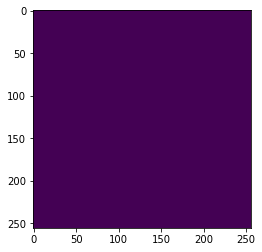

0.0

In [134]:
image_cover = image_cover/255
image_stego = image_stego/255
plt.imshow(image_cover-image_stego)
plt.show()
abs(image_cover-image_stego).mean()

In [119]:
(first_images[2]-first_images[3]).mean()

0.0

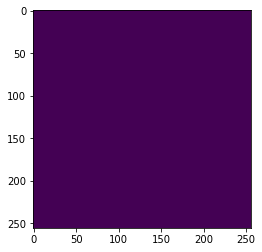

In [120]:
plt.imshow((first_images[2]-first_images[3]))

In [95]:
abs((first_images[2]-first_images[3])).mean()

0.0

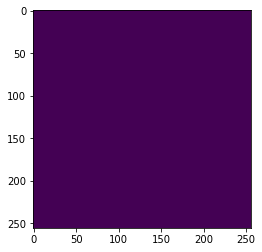

In [96]:
plt.imshow((first_images[2]-first_images[3]))

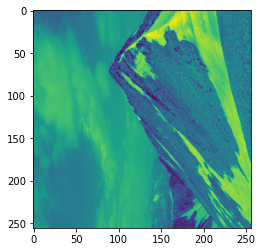

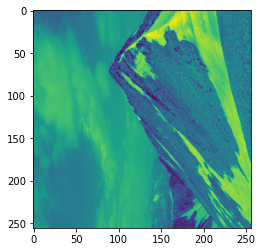

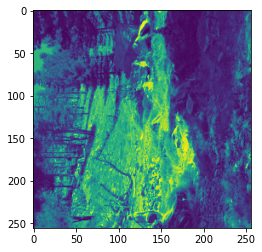

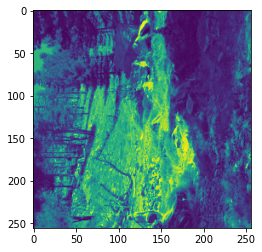

In [97]:
batch = val_generator.__getitem__(0)

first_images = batch[0][0:4]

# Plot of several images to check how they enter the network
for np_image in first_images:
    plt.imshow(np_image, )
    plt.show()

In [98]:
abs((first_images[2]-first_images[3])).mean()

0.0

model


blocks

In [73]:
class Type1(keras.Model ):
    def __init__(self,filters,kernel=(3,3),*args,**kwargs):
        super(Type1, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters,
                                           kernel,
                                           padding="same",
                                           kernel_initializer=tf.keras.initializers.HeNormal(),
                                           kernel_regularizer=tf.keras.regularizers.L2(l2=2e-4),
                                           bias_initializer=tf.keras.initializers.Constant(0.2),
                                        )
        self.bn=tf.keras.layers.BatchNormalization(momentum=0.9)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = tf.nn.relu(x)
        return x

    

In [48]:
import itertools

for images, labels in itertools.islice(train_generator,2):
    print(Type1(4)(images).shape)

(16, 256, 256, 4)
(16, 256, 256, 4)


In [49]:
class Type2(keras.Model ):
    def __init__(self,filters,kernel=(3,3),*args,**kwargs):
        super(Type2, self).__init__()
        self.type1=Type1(filters,kernel)
        self.conv = tf.keras.layers.Conv2D(filters,
                                           kernel,
                                           padding="same",
                                           kernel_initializer=tf.keras.initializers.HeNormal(),
                                           kernel_regularizer=tf.keras.regularizers.L2(l2=2e-4),
                                           bias_initializer=tf.keras.initializers.Constant(0.2),
                                        )
        self.bn=tf.keras.layers.BatchNormalization(momentum=0.9)

    def call(self, inputs):
        x=self.type1(inputs)
        x = self.conv(x)
        x = self.bn(x)
        x = x+inputs
        return x


In [50]:
class Type3(keras.Model ):
    def __init__(self,filters,kernel=(3,3),*args,**kwargs):
        super(Type3, self).__init__()
        self.type1=Type1(filters,kernel)
        self.conv1 = tf.keras.layers.Conv2D(filters,(1,1),strides=2,
                                           padding="same",
                                           kernel_initializer=tf.keras.initializers.HeNormal(),
                                           kernel_regularizer=tf.keras.regularizers.L2(l2=2e-4),
                                           bias_initializer=tf.keras.initializers.Constant(0.2),
                                        )
        self.conv = tf.keras.layers.Conv2D(filters,
                                           kernel,
                                           padding="same",
                                           kernel_initializer=tf.keras.initializers.HeNormal(),
                                           kernel_regularizer=tf.keras.regularizers.L2(l2=2e-4),
                                           bias_initializer=tf.keras.initializers.Constant(0.2),
                                        )
        self.bn=tf.keras.layers.BatchNormalization(momentum=0.9)
    def call(self, inputs):
        x=self.type1(inputs)
        x = self.conv(x)
        x = self.bn(x)
        x = tf.keras.layers.AveragePooling2D(pool_size=kernel, strides=2,padding="same")(x)
        y=self.conv1(inputs)
        y=self.bn(y)
        return x+y

In [51]:
class Type4(keras.Model):
    def __init__(self,filters,kernel=(3,3),*args,**kwargs):
        super(Type4, self).__init__()
        self.type1=Type1(filters,kernel)
        self.conv = tf.keras.layers.Conv2D(filters,
                                           kernel,
                                           padding="same",
                                           kernel_initializer=tf.keras.initializers.HeNormal(),
                                           kernel_regularizer=tf.keras.regularizers.L2(l2=2e-4),
                                           bias_initializer=tf.keras.initializers.Constant(0.2),
                                        )
        self.bn=tf.keras.layers.BatchNormalization(momentum=0.9)
    def call(self, inputs):
        x=self.type1(inputs)
        x = self.conv(x)
        x = self.bn(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        return x

In [52]:
kernel=(3,3)
inputs = keras.Input(shape=( 256, 256,1), )
x=Type1(64,)(inputs)
x=Type1(16,)(x)

x=Type2(16,)(x)
x=Type2(16,)(x)
x=Type2(16,)(x)
x=Type2(16,)(x)
x=Type2(16,)(x)

x=Type3(16,)(x)
x=Type3(64,)(x)
x=Type3(128,)(x)
x=Type3(256,)(x)
x=Type4(512,)(x)

outputs=tf.keras.layers.Dense(1,
                              activation='sigmoid',
                             kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=.01))(x)

model = keras.Model(inputs=inputs, outputs=outputs)



In [53]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 type1_16 (Type1)            (None, 256, 256, 64)      896       
                                                                 
 type1_17 (Type1)            (None, 256, 256, 16)      9296      
                                                                 
 type2_5 (Type2)             (None, 256, 256, 16)      4768      
                                                                 
 type2_6 (Type2)             (None, 256, 256, 16)      4768      
                                                                 
 type2_7 (Type2)             (None, 256, 256, 16)      4768      
                                                                 
 type2_8 (Type2)             (None, 256, 256, 16)      4768

In [54]:

model.compile(optimizer='adamax',#initial learning rate is 0.001
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'],
            )

In [55]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        try:
          del logs["lr"]
        except:
          pass 
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        try:
          del logs["lr"]
        except:
          pass
          # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [64]:
from plot_model import plot_model
plot_model(model)

AttributeError: 'NoneType' object has no attribute 'summary'

In [ ]:
from tensorflow.keras import wrappers

AttributeError: 'NoneType' object has no attribute 'built'

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
Type, to_file='model.png', show_shapes=True, show_dtype=True,
show_layer_names=True, expand_nested=True, dpi=96
)

AttributeError: type object 'Type1' has no attribute 'built'

In [66]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=True, show_dtype=True,
show_layer_names=True, expand_nested=True, dpi=96
)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [62]:
sudo apt-get install graphviz



SyntaxError: invalid syntax (2725873773.py, line 1)

In [71]:

def lr_schedule(epoch):
    if epoch <= (300-45):
        return 0.001
    else:
        return 0.0001

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
model_checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(r"C:\Users\Nikolay\Downloads\srnet\Downloads\srnet\checkpoint_pgm",
                                                              monitor="loss",
                                                              verbose=1,
                                                              save_freq='epoch',
                                                              save_weights_only=False, )

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if not bool(epoch%5):  # or save after some epoch, each k-th epoch etc.
            self.model.save(os.path.join(r"C:\Users\Nikolay\Downloads\srnet\Downloads\srnet\checkpoint_pgm","model_{}.hd5".format(epoch)))
model_checkpoint_callback=CustomSaver()      
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join("Downloads/srnet/", 'training_pgm_log.csv'), append=True, separator=';')


In [72]:
model(train_generator[0][0])

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

In [73]:
train_generator[0][1]

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [74]:
val_generator[0][0].shape

(16, 256, 256, 1)

In [75]:
model.evaluate(val_generator,verbose=1)

 39/125 [========>.....................] - ETA: 4:43 - loss: 991.5370 - accuracy: 0.5000

KeyboardInterrupt: 

In [72]:
if True:
    model=tf.keras.models.load_model(r"C:\Users\CoolerMaster\Downloads\model_42.hd5")
    print(model.evaluate(train_generator,verbose=1))

1750/1750 [==============================] - 108s 61ms/step - loss: 1.2906 - accuracy: 0.6024
[1.2905631065368652, 0.602392852306366]


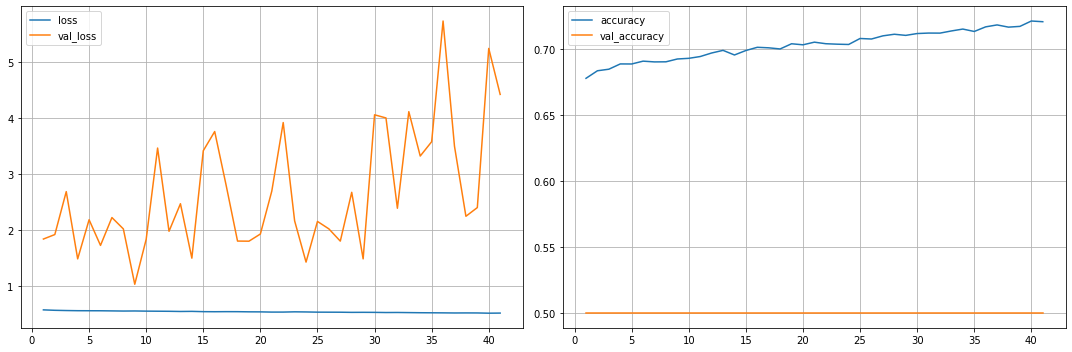

1750/1750 [==============================] - 410s 235ms/step - loss: 0.5255 - accuracy: 0.7209 - val_loss: 4.4235 - val_accuracy: 0.5000
Epoch 42/412
1750/1750 [==============================] - ETA: 0s - loss: 0.5247 - accuracy: 0.7195

KeyboardInterrupt: 

In [73]:
epochs=457-45
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[csv_logger, lr_scheduler_callback,model_checkpoint_callback,PlotLearning()],)

In [ ]:
train_generator[0][1]

In [ ]:
"""batch_size=16
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Select where to obtain the images from and some parameters
test_generator = test_datagen.flow_from_directory(r"C:\Users\Nikolay\Downloads\srnet/data_directory/test",
                                                target_size=(256, 256),
                                                batch_size=batch_size,
                                                class_mode="binary",
                                                color_mode='grayscale',
                                                shuffle=True,)"""

In [ ]:
print(model.evaluate(test_generator,verbose=1))

NameError: name 'tf' is not defined

# Evaluation

In [88]:
from PIL import ImageFont
import visualkeras
model=tf.keras.models.load_model(r"C:\Users\Home\Downloads\SRNet-Tensorflow-Implementation-main\trained_models\SRNet-PairedBatches-2\checkpoints\best_model.h5")
model=tf.keras.models.load_model(r"C:\Users\Home\Downloads\model_0.hd5")


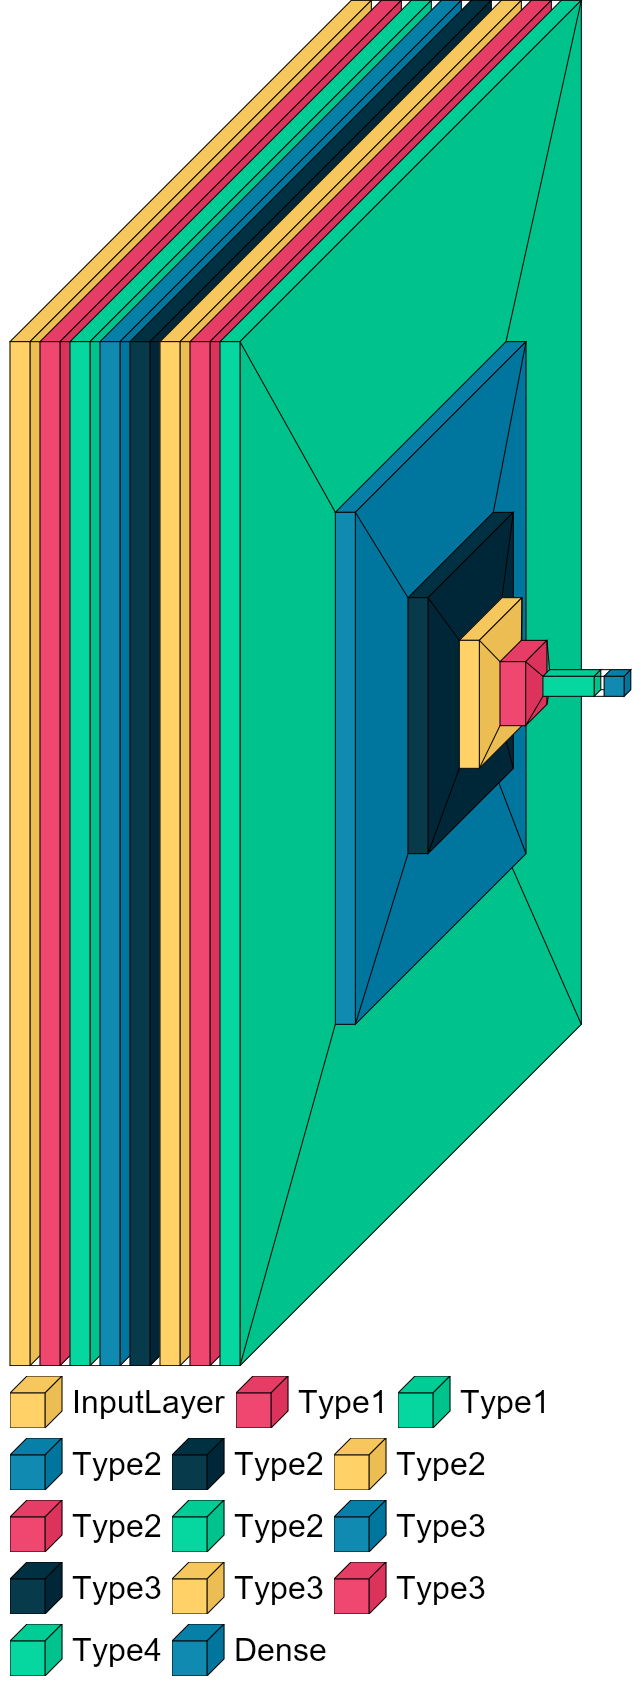

In [89]:
from collections import defaultdict

color_map = defaultdict(dict)
font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font)  # font is optional!


In [64]:
model.layers

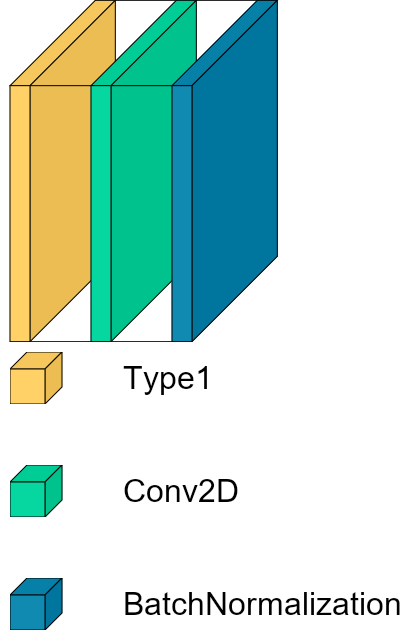

<Figure size 1440x216 with 0 Axes>

In [125]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=( 64,64,10)))

model.add(Type1(1))
model.add(tf.keras.layers.Conv2D(1,1))
model.add(tf.keras.layers.BatchNormalization())

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
from collections import defaultdict
plt.figure(figsize=(20,3))
color_map = defaultdict(dict)
color_map[tf.keras.layers.Conv2D]['fill'] = '#06D6A0'
color_map[tf.keras.layers.BatchNormalization]['fill'] = '#118AB2'
visualkeras.layered_view(model,spacing=61, legend=True, font=font,color_map=color_map)  # font is optional!


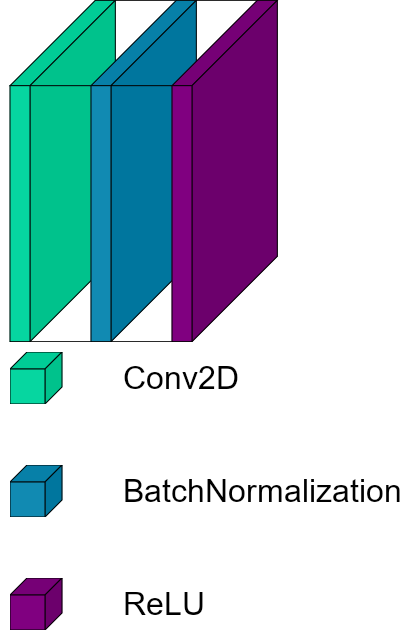

<Figure size 1440x216 with 0 Axes>

In [126]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=( 64,64,10)))

model.add(tf.keras.layers.Conv2D(1,1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
from collections import defaultdict
plt.figure(figsize=(20,3))
color_map = defaultdict(dict)
color_map[tf.keras.layers.Conv2D]['fill'] = '#06D6A0'
color_map[tf.keras.layers.BatchNormalization]['fill'] = '#118AB2'
color_map[tf.keras.layers.ReLU]['fill'] = 'purple'

visualkeras.layered_view(model,spacing=61, legend=True, font=font,color_map=color_map)  # font is optional!


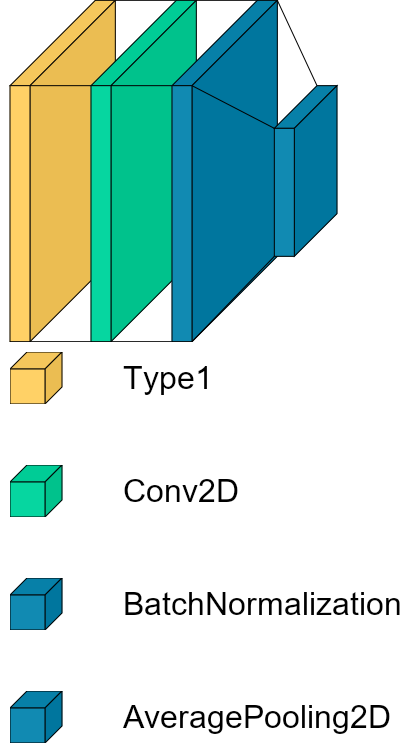

<Figure size 1440x216 with 0 Axes>

In [127]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=( 64,64,10)))
model.add(Type1(1))
model.add(tf.keras.layers.Conv2D(1,1,))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.AveragePooling2D())

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
from collections import defaultdict
plt.figure(figsize=(20,3))
color_map = defaultdict(dict)
color_map[tf.keras.layers.Conv2D]['fill'] = '#06D6A0'
color_map[tf.keras.layers.BatchNormalization]['fill'] = '#118AB2'
visualkeras.layered_view(model,spacing=61, legend=True, font=font,color_map=color_map)  # font is optional!


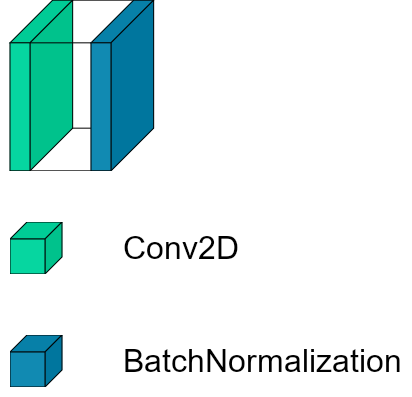

<Figure size 1440x216 with 0 Axes>

In [128]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=( 64,64,10)))
model.add(tf.keras.layers.Conv2D(1,1,strides=2))
model.add(tf.keras.layers.BatchNormalization())


font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
from collections import defaultdict
plt.figure(figsize=(20,3))
color_map = defaultdict(dict)
color_map[tf.keras.layers.Conv2D]['fill'] = '#06D6A0'
color_map[tf.keras.layers.BatchNormalization]['fill'] = '#118AB2'
visualkeras.layered_view(model,spacing=61, legend=True, font=font,color_map=color_map)  # font is optional!


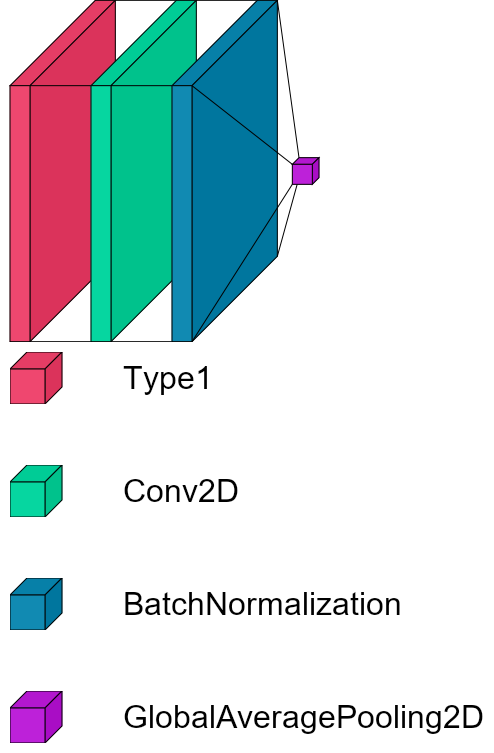

<Figure size 1440x216 with 0 Axes>

In [129]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=( 64,64,10)))
model.add(Type1(1))
model.add(tf.keras.layers.Conv2D(1,1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalAveragePooling2D())


font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
from collections import defaultdict
plt.figure(figsize=(20,3))
color_map = defaultdict(dict)
color_map[Type1]['fill'] ="#EF476F"
color_map[tf.keras.layers.Conv2D]['fill'] = '#06D6A0'
color_map[tf.keras.layers.BatchNormalization]['fill'] = '#118AB2'
color_map[tf.keras.layers.GlobalAveragePooling2D]['fill'] = '#BD21D9'

visualkeras.layered_view(model,spacing=61, legend=True, font=font,color_map=color_map)  # font is optional!


In [67]:
df=pd.read_csv(r"C:\Users\Home\Downloads/training_pgm_log.csv",sep=";")

In [68]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


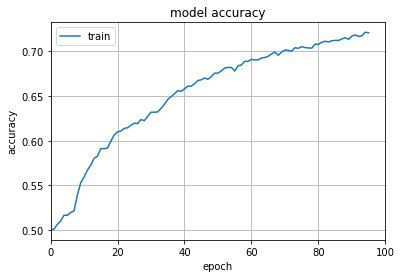

(0.0, 100.0)

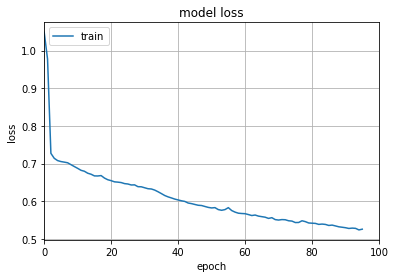

In [69]:
plt.plot(df["accuracy"][:96])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.xlim(0,100)
plt.grid()
plt.show()
plt.plot(df["loss"][:96])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.grid()
plt.xlim(0,100)

In [126]:
os_dir=r"C:\Users\Home\Downloads\test_results"
true = np.array([1/2+((1/2)*(-1) ** n) for n in range(10000)])
true_neg=(~true.astype(bool)).astype(int)
i=5
#my
pred_bows_test=np.load(os.path.join(os_dir,f"boss_bows\\{i}\\boss_bows_pred_0{i}.npy"))
true_bows_test=true
#np.load(os.path.join(os_dir,r"boss_bows\5\true_dataset_test.npy"))
#pytorch
pred_pyt_test=np.load(os.path.join(os_dir,f"pytorch\\{i}\\predicted_0{i}.npy"))
pred_pyt_test_1d=pred_pyt_test[:,1]
true_pyt_test=np.load(os.path.join(os_dir,f"pytorch\\{i}\\true_0{i}.npy"))
#add
pred_add_test=np.load(os.path.join(os_dir,f"additional_layer\\{i}\\pred_0{i}.npy"))
true_add_test=true

In [127]:
fpr_add.shape

(2974,)

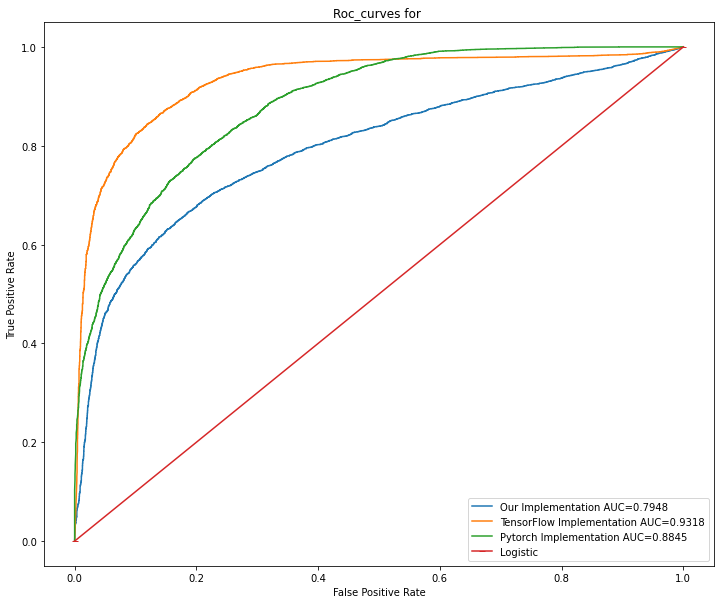

In [128]:
fpr_bows, tpr_bows, proba_bows = roc_curve(true_neg,pred_bows_test)
fpr_add, tpr_add, proba_add = roc_curve(true_neg,pred_add_test)
fpr_pyt, tpr_pyt, proba_pyt = roc_curve(true_neg,pred_pyt_test_1d)

ns_probs = [0 for _ in range(len(true))]

ns_fpr, ns_tpr, proba_ns= roc_curve(true,ns_probs)

plt.figure(figsize=(12,10))

auc_bows = roc_auc_score(true_neg,pred_bows_test)
plt.plot(fpr_bows,tpr_bows,label="Our Implementation AUC="+str(round(auc_bows,4)))

auc_add = roc_auc_score(true_neg,pred_add_test)
plt.plot(fpr_add,tpr_add,label="TensorFlow Implementation AUC="+str(round(auc_add,4)))

auc_pyt = roc_auc_score(true_neg,pred_pyt_test_1d)
plt.plot(fpr_pyt,tpr_pyt,label="Pytorch Implementation AUC="+str(round(auc_pyt,4)))

plt.plot(ns_fpr, ns_tpr, marker='_', label='Logistic')
plt.title("Roc_curves for ")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

In [129]:
pred_pyt_test_1d=np.argmax(pred_pyt_test,axis=1)


In [130]:
#youden-s-j-statistic      https://www.kaggle.com/code/willstone98/youden-s-j-statistic-for-threshold-determination/notebook

optimal_proba_cutoff_bows = sorted(list(zip(np.abs(tpr_bows - fpr_bows), proba_bows)), key=lambda i: i[0], reverse=True)[0][1]
print("my implementation acc = ",accuracy_score((pred_bows_test>optimal_proba_cutoff_bows).astype(int),true_neg,))

optimal_proba_cutoff_add = sorted(list(zip(np.abs(tpr_add - fpr_add), proba_add)), key=lambda i: i[0], reverse=True)[0][1]
print("additional layer implementation acc = ",accuracy_score((pred_add_test>optimal_proba_cutoff_add).astype(int),true_neg,))

optimal_proba_cutoff_pyt = sorted(list(zip(np.abs(tpr_pyt - fpr_pyt), proba_pyt)), key=lambda i: i[0], reverse=True)[0][1]
print("pytorch implementation acc = ",accuracy_score(pred_pyt_test_1d,true_neg,))

my implementation acc =  0.7396
additional layer implementation acc =  0.8622
pytorch implementation acc =  0.7874


In [131]:
#youden-s-j-statistic      https://www.kaggle.com/code/willstone98/youden-s-j-statistic-for-threshold-determination/notebook

optimal_proba_cutoff_bows = sorted(list(zip(np.abs(tpr_bows - fpr_bows), proba_bows)), key=lambda i: i[0], reverse=True)[0][1]
print("my implementation acc = ",round(recall_score((pred_bows_test>optimal_proba_cutoff_bows).astype(int),true_neg,),4))

optimal_proba_cutoff_add = sorted(list(zip(np.abs(tpr_add - fpr_add), proba_add)), key=lambda i: i[0], reverse=True)[0][1]
print("additional layer implementation acc = ",round(recall_score((pred_add_test>optimal_proba_cutoff_add).astype(int),true_neg,),4))

optimal_proba_cutoff_pyt = sorted(list(zip(np.abs(tpr_pyt - fpr_pyt), proba_pyt)), key=lambda i: i[0], reverse=True)[0][1]
print("pytorch implementation acc = ",round(recall_score(pred_pyt_test_1d,true_neg,),4))

my implementation acc =  0.7807
additional layer implementation acc =  0.8768
pytorch implementation acc =  0.7835


In [132]:
#youden-s-j-statistic      https://www.kaggle.com/code/willstone98/youden-s-j-statistic-for-threshold-determination/notebook

optimal_proba_cutoff_bows = sorted(list(zip(np.abs(tpr_bows - fpr_bows), proba_bows)), key=lambda i: i[0], reverse=True)[0][1]
print("my implementation acc = ",round(precision_score((pred_bows_test>optimal_proba_cutoff_bows).astype(int),true_neg,),4))

optimal_proba_cutoff_add = sorted(list(zip(np.abs(tpr_add - fpr_add), proba_add)), key=lambda i: i[0], reverse=True)[0][1]
print("additional layer implementation acc = ",round(precision_score((pred_add_test>optimal_proba_cutoff_add).astype(int),true_neg,),4))

optimal_proba_cutoff_pyt = sorted(list(zip(np.abs(tpr_pyt - fpr_pyt), proba_pyt)), key=lambda i: i[0], reverse=True)[0][1]
print("pytorch implementation acc = ",round(precision_score(pred_pyt_test_1d,true_neg,),4))

my implementation acc =  0.6664
additional layer implementation acc =  0.8428
pytorch implementation acc =  0.7942


In [133]:
#youden-s-j-statistic      https://www.kaggle.com/code/willstone98/youden-s-j-statistic-for-threshold-determination/notebook

optimal_proba_cutoff_bows = sorted(list(zip(np.abs(tpr_bows - fpr_bows), proba_bows)), key=lambda i: i[0], reverse=True)[0][1]
print("my implementation acc = ",round(f1_score((pred_bows_test>optimal_proba_cutoff_bows).astype(int),true_neg,),4))

optimal_proba_cutoff_add = sorted(list(zip(np.abs(tpr_add - fpr_add), proba_add)), key=lambda i: i[0], reverse=True)[0][1]
print("additional layer implementation acc = ",round(f1_score((pred_add_test>optimal_proba_cutoff_add).astype(int),true_neg,),4))

optimal_proba_cutoff_pyt = sorted(list(zip(np.abs(tpr_pyt - fpr_pyt), proba_pyt)), key=lambda i: i[0], reverse=True)[0][1]
print("pytorch implementation acc = ",round(f1_score(pred_pyt_test_1d,true_neg,),4))

my implementation acc =  0.719
additional layer implementation acc =  0.8595
pytorch implementation acc =  0.7888


In [134]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


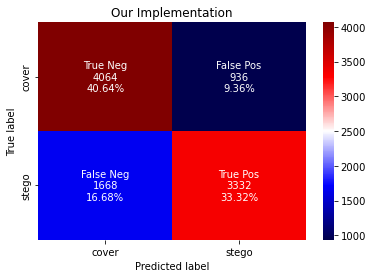

In [135]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['cover', 'stego']

make_confusion_matrix(confusion_matrix(true_neg,(pred_bows_test>optimal_proba_cutoff_bows).astype(int),).astype(int), 
                      group_names=labels,
                      categories=categories, 
                      sum_stats=False,
                      title="Our Implementation",
                      cmap='seismic')

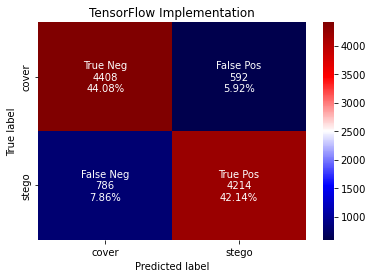

In [136]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['cover', 'stego']
make_confusion_matrix(confusion_matrix(true_neg,(pred_add_test>optimal_proba_cutoff_add).astype(int)), 
                      group_names=labels,
                      categories=categories, 
                      sum_stats=False,
                      title="TensorFlow Implementation",
                      cmap='seismic')

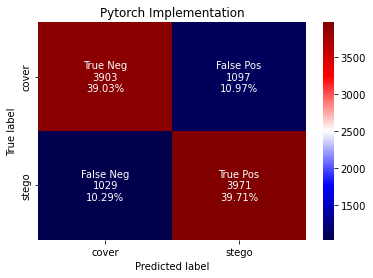

In [137]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['cover', 'stego']
make_confusion_matrix(confusion_matrix(true_neg,pred_pyt_test_1d), 
                      group_names=labels,
                      categories=categories, 
                      sum_stats=False,
                      title="Pytorch Implementation",
                      cmap='seismic')